# EMAILS NETWORKS


In this case we align the for email networks from a University after filtering the suitable nodes to align (see Methods and Data).

There is information about the departments, so we introduce it as group information.
In this case we impose some nodes to be anchors (synthetically, chosen randomly and proportionally to the group size)


In [1]:
import itertools
import pickle
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import os
import time
from numba import jit, njit
from numba.types import bool_, int_, float32
from math import comb
from copy import deepcopy
from tqdm import tqdm
import networkx as nx
import pandas as pd
from collections import defaultdict

# DATASET 

Dataset after the filtering indicated in the main paper

In [3]:

d_store_upper = pickle.load(open("mails_07_10_upperthreshold_25_5links.pickle", "rb"))
schosen = "_some_some"
string = "M" + schosen
M_square_bin = d_store_upper[string]
tablas = M_square_bin.shape[0]
rows, columns = M_square_bin.shape[1] , M_square_bin.shape[2]


# Functions

Functions for computing the energy of the alignment

In [9]:
@jit(nopython = True)
def hamiltonian_prob(Edges_NoL, Edges_L, overlap_0, overlap_1, alpha, beta):
    n1 = int(Edges_L + alpha + beta - 2)
    k1 = overlap_1 + alpha -1
    
    n0 = int(Edges_NoL + alpha + beta - 2)
    k0 = overlap_0 + alpha - 1
    
    # !!!! Numba [ math.lgamma(n+1) == log(n!) ]
    H1 = math.lgamma(n1+1)- math.lgamma(k1+1) - math.lgamma(n1-k1 +1) + math.log( Edges_L + alpha+beta-1)
    H0 = math.lgamma(n0+1)- math.lgamma(k0+1) - math.lgamma(n0-k0 +1) + math.log( Edges_NoL + alpha+beta-1)
    
    H = H1 + H0

    return H
    
    
@jit(nopython=True)
def overlap_total_prob(L_f, A_f, P_inv_f):
    Nx = L_f.shape[0]
    Ny = L_f.shape[1]
    K = A_f.shape[0]
    
    ovlp_0, ovlp_1 = 0,0
    for k in range(0,K):
        for f in range(0,Ny):
            for c in range(0,Nx):
                p_f=int(P_inv_f[k,f])
                p_c=int(P_inv_f[k,c])           
            
                if (L_f[f,c] == A_f[k,p_f,p_c]): #Antes tenía esto al revés
                    if (L_f[f,c] == 1):
                        ovlp_1 = ovlp_1+1
                    else:
                        ovlp_0 = ovlp_0 +1

    return ovlp_0, ovlp_1

@jit(nopython=True)
#In each step the latent matrix is also stored
def L_wiring(A_f, P_inv_f):
    Nx = A_f.shape[1]
    Ny = A_f.shape[2]
    K = A_f.shape[0]
    L_new_f = np.zeros((Nx,Ny))
    
    for i in range(0,Nx):
        for j in range(0,Ny):
            for k in range(0,K):
                p1 = int(P_inv_f[k,i]) 
                p2 = int(P_inv_f[k,j]) 
                L_new_f[i,j] += A_f[k,p1,p2]
            # Each entry averaged over all the network
            valor_lnew=1/K* L_new_f[i,j]
            L_new_f[i,j] = round( valor_lnew )

    return L_new_f
    
#Este tiene en cuenta una lista secundaria
#(que puede ser por ejemplo el hub de mayor tamaño)
@jit(nopython=True)
def partition(array,  etiquetas, begin, end):
    pivot = begin
    for i in range(begin+1, end+1):
        if array[i] < array[begin]:
            pivot += 1
            array[i], array[pivot] = array[pivot], array[i]
            etiquetas[i], etiquetas[pivot] = etiquetas[pivot], etiquetas[i]
    array[pivot], array[begin] = array[begin], array[pivot]
    etiquetas[pivot], etiquetas[begin] = etiquetas[begin], etiquetas[pivot] 

    return pivot
@jit(nopython=True)
def quicksort(array, etiquetas, begin=0, end=None):
    #print('dentro:',array, begin, end)
    if end is None:
        end = len(array) - 1
    if begin >= end: #Para acabar el algoritmo
        return
    pivot = partition(array,  etiquetas, begin, end)
    #print('pivot', pivot, 'array', array)
    
    #Aquí ordenamos la derecha y la izquierda
    quicksort(array, etiquetas, begin, pivot-1)
    quicksort(array,  etiquetas, pivot+1, end)
    
@njit 
# Ordering according the node degree taking into account the groups
def permu_groups(L_f, A_f, start_f): 
    Nx = L_f.shape[0]
    Ny = L_f.shape[1]
    K = A_f.shape[0]
    N_groups = len(start_f)
    
    P_f=np.zeros((K,Nx))
    P_inv_f=np.zeros((K,Nx))
    P_new=np.zeros((K,Nx))
    
    #Ordering accroding node degree Latent
    orden_L=np.zeros((Nx))
    for i in range(Nx):
        b=np.nonzero(L_f[i,:])
        orden_L[i] = b[0].size#.size
        
    array_L = np.arange(Nx)
    quicksort(orden_L, array_L)
    # Taking into account the groups
    array_L_labels = np.zeros((Nx))
    group_number = np.zeros((N_groups))
    for i in range(Nx):
        n_type = 0
        while ( (array_L[i] >= start_f[n_type]) and (n_type < N_groups)):
            n_type += 1
        grupo = int(n_type-1)
        g = int(start_f[grupo])
        array_L_labels[g + int(group_number[grupo])] = array_L[i]
        group_number[grupo] += 1

   
    #Ordering connectomes
    for i in range(0,K):
        orden_A = np.zeros((Nx))
        for i_orden in range(Nx):
            b = np.nonzero(A_f[i,i_orden,:])
            orden_A[i_orden] = b[0].size

        array_A = np.arange(Nx) 
        quicksort(orden_A, array_A)

        ## Groups
        array_A_labels = np.zeros((Nx))
        group_number = np.zeros((N_groups))
        
        for i_g in range(Nx):
            n_type = 0
            while ( (array_A[i_g] >= start_f[n_type]) and (n_type < N_groups) ):
                n_type += 1

            grupo = int(n_type-1)
            g = int(start_f[grupo])
            array_A_labels[ g + int(group_number[grupo])] = array_A[i_g]
            group_number[grupo] += 1

        array_A_labels = array_A_labels[np.argsort(array_L_labels)]
        P_f[i,:] = array_A_labels
        
        for i_inv in range(0,Nx):
            for j_inv in range(0,Ny):
                if (P_f[i,i_inv] == j_inv):
                    P_inv_f[i, j_inv]=i_inv
    
    P_todo = np.zeros((2,K,Nx))
    P_todo[0,:,:] = P_f.copy()
    P_todo[1,:,:] = P_inv_f.copy()

    
    return P_todo

@njit 
#In case we want random initialization
def random_groups(L_f, A_f, start_f, end_f): 
    Nx = L_f.shape[0]
    Ny = L_f.shape[1]
    K = A_f.shape[0]
    N_groups = len(start_f)
    
    
    #Matrices permutación y sus inversas
    P_f=np.zeros((K,Nx))
    P_inv_f=np.zeros((K,Nx))
    P_new=np.zeros((K,Nx))
    
    for i in range(0,K):
        for i_g in range(N_groups):
            start = start_f[i_g]
            end = end_f[i_g]
            
            ordenado = np.arange(start, end)
            np.random.shuffle(ordenado)
            P_f[i,start:end] = ordenado
        for i_inv in range(0,Nx):
            for j_inv in range(0,Ny):
                if (P_f[i,i_inv] == j_inv):
                    P_inv_f[i, j_inv]=i_inv

    
    P_todo = np.zeros((2,K,Nx))
    P_todo[0,:,:] = P_f.copy()
    P_todo[1,:,:] = P_inv_f.copy()

    
    
    return P_todo

## In the case we have anchors
def permu_groups_capa1_anchors_knwn(L_f, A_f, start_f,grupos_t, Anchors,grupos_extra): 
   
    Nx = L_f.shape[0]
    Ny = L_f.shape[1]
    K = A_f.shape[0]
    N_groups = len(start_f)
    start_2 = np.zeros((len(start_f)))
    start_2[1:] = np.cumsum(grupos_extra)[:-1]
    start_anchor = start_f - start_2   
    start_anchor = start_anchor.astype(int)
    
    P_f = np.zeros((K,Nx))
    P_inv_f = np.zeros((K,Nx))
    P_new = np.zeros((K,Nx))
    
    
    n_an = len(Anchors)
    P_f[:,:n_an] = Anchors
    
    orden_L_in = np.zeros((Nx-n_an ))
    array_L = np.zeros((Nx-n_an ))
    c_o = 0

    for i in range(Nx):
        if (i not in Anchors):
            b = np.nonzero(L_f[i,:])
            array_L[c_o] = i
            orden_L_in[c_o] = b[0].size
            c_o += 1
     
    orden_L = orden_L_in.copy()
    quicksort(orden_L, array_L)
    array_L = array_L[::-1]

    grupos_L = np.zeros((Nx-n_an))
    for  i_g in range(N_groups):
        start = start_anchor[i_g]
        if (i_g != N_groups-1):
            end = start_anchor[i_g+1]
        else:
            end = Nx-n_an
        grupos_L[start:end] = i_g
    grupos_L = grupos_L.astype(int)
    orden_L = orden_L_in.copy()
    quicksort(orden_L, grupos_L )
    grupos_L = grupos_L[::-1]

    for i in range(0,K):
        orden_A_in = np.zeros((Nx- n_an))
        array_A = np.zeros((Nx-n_an))
        grupos_A = np.zeros((Nx-n_an))
        c_o = 0
        for i_orden in range(Nx):
            if (i_orden not in Anchors):
                b = np.nonzero(A_f[i,i_orden,:])
                array_A[c_o] = i_orden
                grupos_A[c_o] = grupos_t[i, i_orden]
                orden_A_in[c_o] = b[0].size#.size
                c_o += 1
        
        orden_A = orden_A_in.copy()
        quicksort(orden_A, array_A)  
        array_A = array_A[::-1]

        orden_A = orden_A_in.copy()
        quicksort(orden_A, grupos_A)
        grupos_A = grupos_A[::-1]

        
        array_A_L = np.zeros((Nx - n_an))
        for i_n in range(Nx-n_an):
            if ((grupos_A[i_n] == grupos_L[i_n])):
                array_A_L[i_n] = array_A[i_n]
            else:
                count = 0
                for i_nn in range(i_n, Nx-n_an):
                    if ((grupos_A[i_nn] == grupos_L[i_n])): 
                        array_A_L[i_n] = array_A[i_nn]
                        array_A[i_nn] = array_A[i_n]
                        aux = grupos_A[i_nn]
                        grupos_A[i_nn] = grupos_A[i_n]
                        grupos_A[i_n] = aux
                        count = 1
                        break
        array_A_L = array_A_L[np.argsort(array_L)]
        P_f[i,n_an:] = array_A_L
        
        for i_inv in range(0,Nx):
            for j_inv in range(0,Ny):
                if (P_f[i,i_inv] == j_inv):
                    P_inv_f[i, j_inv]=i_inv
    
    P_todo = np.zeros((2,K,Nx))
    P_todo[0,:,:] = P_f.copy()
    P_todo[1,:,:] = P_inv_f.copy()

        

    
    
    return P_todo

# INITIAL CONDITIONS AND GROUPS

In [10]:
# This change of the name is because we had different filtering data
s = "start_groups" + schosen
start_groups = d_store_upper[s]
s = "end_groups" + schosen
end_groups = d_store_upper[s] 
s = "size_groups" + schosen
size_groups = d_store_upper[s]
s = "groups_users_names"
names_groups = d_store_upper[s] 
n_groups = len(size_groups)
print('SIZE GROUPS:', size_groups)


print('starting nodes by groups:', start_groups)
Nx, Ny = rows, rows #Nodos en la red

K = tablas # Number of networks,  correspondence to different years
alpha,beta = 5,2 # Beta distribution
Edges = Nx*Ny #Entries of the Latent matrix
micropasos = Edges*K # Microsteps for a MCMC step

np.random.seed(np.random.randint(199))


A = np.zeros((K,Nx,Ny))
A = M_square_bin[:, :,:].copy()
A_ini = A.copy()               

####################################
## INITIALISE ##
L_ini = np.zeros((Nx,Ny))
P_ini = np.zeros((K,Nx))
P_inv_ini = np.zeros((K,Nx))
L_ini = (A[0,:,:]).copy()

groups_ini = np.zeros((K,Nx))
for m1 in range(K):
    for i_g in range(n_groups):
        start = start_groups[i_g]
        end = end_groups[i_g]
        groups_ini[m1, start:end] = i_g



SIZE GROUPS: [ 9  2 10  9  3 17  8 22 12 18  3 13  3  1  3  7  6  0  0  2  0  6  6  1
  1  0]
starting nodes by groups: [  0   9  11  21  30  33  50  58  80  92 110 113 126 129 130 133 140 146
 146 146 148 148 154 160 161 162]


# Anchors 

Anchors have been chosen proportional to the group size


In [11]:
s = "anchors_store_5links25years" + schosen + '.pickle'
d_store_anchors = pickle.load(open(s, "rb"))
start_anchor = d_store_anchors["start_anchors"]     
end_anchor = d_store_anchors["end_anchor"]
grupos_extra = d_store_anchors["anchors_group"] 
Anchors = d_store_anchors["anchors_all"] 

In [12]:
P_inis = permu_groups_capa1_anchors_knwn(L_ini, A, start_groups,groups_ini, Anchors, grupos_extra) 
P_inis = P_inis.astype(int)
P_ini_0 = (P_inis[0,:,:]).copy()#
P_inv_ini_0 = (P_inis[1,:,:]).copy()


*************************
[[  0  11  12  25  38  39  46  55  60  62  65  73  83  91  98 103 109 118
  123 134 140 151 157   1   2   3   4   5   6   7   8   9  10  13  14  15
   16  17  18  19  20  21  22  23  24  26  27  28  29  30  31  32  33  34
   35  36  37  40  41  42  43  44  45  47  48  49  50  51  52  53  54  56
   57  58  59  61  63  64  66  67  68  69  70  71  72  74  75  76  77  78
   79  80  81  82  84  85  86  87  88  89  90  92  93  94  95  96  97  99
  100 101 102 104 105 106 107 108 110 111 112 113 114 115 116 117 119 120
  121 122 124 125 126 127 128 129 130 131 132 133 135 136 137 138 139 141
  142 143 144 145 146 147 148 149 150 152 153 154 155 156 158 159 160 161]
 [  0  11  12  25  38  39  46  55  60  62  65  73  83  91  98 103 109 118
  123 134 140 151 157   1   3   2   5   7   6   4   8   9  10  14  15  13
   19  16  18  17  20  21  24  26  22  28  27  29  23  31  30  32  40  34
   45  43  42  35  49  36  44  37  33  47  41  48  53  56  50  51  52  57
   54  77  

# Temperatures

For the parallel tempering we choose temperatures (beta, that actually are 1/T)in the ditribution: T_o ^ alfa, alfa E -[5,5]

In [13]:
beta_o = 1.03
total = 15
b_exp = np.linspace(-5,5,num = total)
tempers = beta_o**b_exp
N_t = len(tempers)

#Initialization
P_ini_t = np.zeros((N_t,K,Nx))
P_inv_ini_t = np.zeros((N_t,K,Nx))
L_ini_t = np.zeros((N_t,Nx,Ny)) 
groups_ini_t = np.zeros((N_t, K, Nx ))

for i in range(0,N_t): #Aquí estoy inicializando para las temperaturas
    P_ini_t[i,:,:] = P_ini_0[:,:].copy()
    P_inv_ini_t[i,:,:] = P_inv_ini_0[:,:].copy()
    L_ini_t[i,:,:] = L_ini.copy()
    groups_ini_t[i,:,:] = groups_ini.copy()


# Functions for the main MonteCarlo Parallel tempering

In [14]:
## FUNCTIONS NEEDED FOR NUMBA

@njit
def concatenate_numba_sinrep(a,b):
    size_a, size_b = len(a), len(b)
    no_double = []
    for i_b in range(size_b):
        if b[i_b] in a:
            size_b = size_b-1
        else:
            no_double.append(b[i_b])
    size = size_a + size_b
    c = np.zeros((size))
    c[0:size_a] = a
    c[size_a:] = no_double
    
    return a

@njit
def concatenate_numba(a,b):
    size_a, size_b = len(a), len(b)
    size = size_a + size_b
    c = np.zeros((size))
    c[0:size_a] = a
    c[size_a:] = b 
    
    return c

@njit
def sum_numba(S):
    Nx = S.shape[0]
    Ny = S.shape[1]
    
    suma = 0
    for i_s in range(Nx):
        suma = suma + sum(S[i_s,:])
        
    return suma
@njit
def sum_numba_filas(S): 
    Nx = S.shape[0]
    Ny = S.shape[1]
    suma = np.zeros((Nx))
    for i_s in range(Nx):
        suma_c = 0 
        for i_y in range(Ny):
            suma[i_s] = suma_c + S[i_y,i_s] 
        
    return suma

@njit
def custom_round(number):
    if number >= 0.5:
        return 1
    else:
        return 0

@njit
def random_menos_mas(number):
    if number >= 0.5:
        return 1
    else:
        return -1

In [15]:
### FUNCTIONS TO UPDATE OVERLAPS AND ENERGY WHEN A CHANGE IS PROPOSED

@jit(nopython=True)
def overlap_total_change_filas(m1,L_f_v1v2_old,L_c_v1v2_old,L_f_v1v2,L_c_v1v2,A_f, P_inv_old, i_change, j_change,pp1, pp2): 

    Nx = L_f_v1v2_old.shape[1]
    K = A_f.shape[0]
    
    ovlp_0_new , ovlp_1_new = 0,0
    ovlp_0_old , ovlp_1_old = 0,0
    ovlp_0_dif, ovlp_1_dif = 0,0
  
    
    changes = np.array([i_change, j_change], dtype = np.int32)
    changes_p = np.array([pp1, pp2], dtype = np.int32)
    changes_p_old = np.array([pp2, pp1], dtype = np.int32)

    for i_k in range(K):
        for i_chan,change in enumerate(changes):
            for i_x in range(Nx):
                if (i_k != m1):
                    p_f = int(P_inv_old[i_k,change])
                    p_c = int(P_inv_old[i_k,i_x])
                    p_old, p_old_c = p_f, p_c
                
                else:
                    p_f = changes_p[i_chan]
                    p_old = changes_p_old[i_chan]

                    if (i_x == i_change):
                        p_c = pp1
                        p_old_c = pp2
                    elif(i_x == j_change):
                        p_c = pp2
                        p_old_c = pp1
                    else:
                        p_c = int(P_inv_old[i_k, i_x])
                        p_old_c = p_c

                ### ROWS
                valor_L_old, valor_A_old = L_f_v1v2_old[i_chan,i_x], A_f[i_k,p_old,p_old_c]
                
                valor_L_new, valor_A_new = L_f_v1v2[i_chan,i_x], A_f[i_k,p_f,p_c]

                # COLUMNS
                column = 0
                if (i_x not in changes):
                    column = 1
                    valor_L_old_c, valor_A_old_c = L_c_v1v2_old[i_chan,i_x],A_f[i_k,p_old_c, p_old]
                    valor_L_new_c, valor_A_new_c = L_c_v1v2[i_chan,i_x], A_f[i_k,p_c,p_f]

                ovlp_1_old = ovlp_1_old + valor_L_old*valor_A_old + valor_L_old_c*valor_A_old_c*column
                ovlp_0_old = ovlp_0_old + (1-valor_L_old)*(1-valor_A_old) + (1-valor_L_old_c)*(1-valor_A_old_c)*column
                
                ovlp_1_new = ovlp_1_new + valor_L_new*valor_A_new + valor_L_new_c*valor_A_new_c*column
                ovlp_0_new = ovlp_0_new + (1-valor_L_new)*(1-valor_A_new) + (1-valor_L_new_c)*(1-valor_A_new_c)*column
                
    ovlp_1_def = ovlp_1_new - ovlp_1_old
    ovlp_0_def = ovlp_0_new- ovlp_0_old

    return ovlp_0_def, ovlp_1_def


##Changes in the rows and columns for the changing
@jit(nopython=True)
def L_wiring_change_filas(m1,L_old,A_f, i_change, j_change, P_inv_old):
    
    Nx = A_f.shape[1]
    Ny = A_f.shape[2]
    K = A_f.shape[0]

    changes = np.array([i_change, j_change])
    changes_new = np.array([j_change, i_change])
    
    L_new_f = L_old.copy()
    L_f_v1v2,L_c_v1v2  = np.zeros((2,Nx)),np.zeros((2,Nx))
    L_new_f[i_change,:], L_new_f[j_change,:], L_new_f[:,i_change], L_new_f[:,j_change] = np.zeros(Nx),np.zeros(Nx),np.zeros(Nx),np.zeros(Nx)

    # Old 
    suma_old =(np.sum(L_old[i_change,:]) + np.sum(L_old[j_change,:]) + np.sum(L_old[:,i_change]) + np.sum(L_old[:,j_change]))-L_old[i_change,j_change]-L_old[j_change,j_change]-L_old[i_change,i_change]-L_old[j_change,i_change]

    # New, ROWS
    suma_1 = 0
    for i_i,i_chan in enumerate(changes):
        for i_x in range(Nx):
            if (i_x not in changes ):
                for k in range(K):
                    if (k == m1):
                        chan_new = changes_new[i_i]
                    else:
                        chan_new = changes[i_i]
                    p1_2 = int (P_inv_old[k,chan_new])
                    p2_2 = int(P_inv_old[k,i_x])

                    L_f_v1v2[i_i,i_x] += A_f[k,p1_2,p2_2]

            else:
                for k in range(K):

                    if (k == m1):
                        chan_new = changes_new[i_i]
                        
                        if (i_x == changes_new[0]):
                            p2_2 = int(P_inv_old[k,changes_new[1]])
                        else:
                            p2_2 = int(P_inv_old[k,changes_new[0]])
                    else:
                        chan_new = changes[i_i]
                        p2_2 = int(P_inv_old[k,i_x])

                    p1_2 = int (P_inv_old[k,chan_new])

                    L_f_v1v2[i_i,i_x] += A_f[k,p1_2,p2_2]
            # Average      
            valor_lnew_2=1/K*  L_f_v1v2[i_i,i_x]
            L_f_v1v2[i_i,i_x] = round( valor_lnew_2 )
      
                    
    ## New, COLUMNs (no crossings )
    for j_j,j_chan in enumerate(changes):
        for i_x in range(Nx):
            changes_x = 0
            if (i_x not in changes):
                for k in range(K):
                    
                    if (k == m1):
                        chan_new = changes_new[j_j]
                    else:
                        chan_new = changes[j_j]
                        
                    p1_2 = int (P_inv_old[k,chan_new])
                    p2_2 = int(P_inv_old[k,i_x])
                    L_c_v1v2[j_j,i_x] += A_f[k,p2_2,p1_2]
                
                valor_lnew_2=1/K* L_c_v1v2[j_j,i_x]
                L_c_v1v2[j_j,i_x] = round( valor_lnew_2)

                    
            else:
                changes_x = 1
                if (i_x == j_chan):
                    L_c_v1v2[j_j,i_x] =  L_f_v1v2[j_j,i_x]
                else:
                    i_x_inv = changes[j_j]
                    if (j_j  == 0):
                        L_c_v1v2[j_j,i_x] =  L_f_v1v2[1,i_x_inv]

                    else:
                        L_c_v1v2[j_j,i_x] =  L_f_v1v2[0,i_x_inv]
           
    suma_new = np.sum(L_f_v1v2[0,:]) + np.sum(L_f_v1v2[1,:]) + np.sum(L_c_v1v2[0,:]) + np.sum(L_c_v1v2[1,:])-L_c_v1v2[0,j_change]-L_c_v1v2[0,i_change]-L_c_v1v2[1,j_change]-L_c_v1v2[1,i_change]
    
    suma_1 = suma_new - suma_old
    
    return L_f_v1v2,L_c_v1v2, suma_1
    

In [21]:
## Main Monte Carlo
@jit(nopython = True)
def parallel_L_knwn_change(c_parallel,fijado_f, N_groups, groups_f, start_f, end_f,A, P_t_f, P_inv_t_f, L_t_f, suma_L,
                      Energy_t_f, ovlp_t_f0, ovlp_t_f1,tempers_f, i_mc):

    
    alpha,beta = 5,2
    N_t = L_t_f.shape[0]
    Nx = L_t_f.shape[1]
    K = A.shape[0]
    Edges_sum = K*Nx*Nx
    N_t_f = len(tempers_f)

    if (c_parallel < 4*Nx): 
        c_parallel += 1
        if (fijado_f == 1):
            m1 = np.random.randint(K-1)+1 # To fix the first layer
        else:
            m1 = np.random.randint(K)    
        
        for k_nt in range(N_t):

            #Movement not in the anchors
            v1 = np.random.randint(start_f[0], Nx)
            grupo = groups_f[k_nt,m1,v1] #Movement inside the group
            start, end = start_f[grupo], end_f[grupo]
            if ((end-start) > 1): #Groups with more than one node
                v2 = np.random.randint(start, end)
                while (v2 == v1):
                    v2 = np.random.randint(start, end)

                v1_mapping = P_inv_t_f[k_nt, m1, v1]
                v2_mapping = P_inv_t_f[k_nt, m1, v2]
                
                pp_1 = v2_mapping 
                pp_2 = v1_mapping 

                #Changes in L_wiring, Recalculating the nodes
                L_f_v1v2, L_f_v1v2_old = np.zeros((2,Nx)),np.zeros((2,Nx))
                L_c_v1v2, L_c_v1v2_old = np.zeros((2,Nx)),np.zeros((2,Nx))
                L_f_v1v2,L_c_v1v2 , suma_aux = L_wiring_change_filas(m1,L_t_f[k_nt,:,:], A, v1, v2, P_inv_t_f[k_nt,:,:])   
                L_f_v1v2_old[0,:],L_f_v1v2_old[1,:] = L_t_f[k_nt,v1,:],L_t_f[k_nt,v2,:]
                L_c_v1v2_old[0,:],L_c_v1v2_old[1,:] = L_t_f[k_nt,:,v1],L_t_f[k_nt,:,v2]

                Edges_L = K*(suma_L[k_nt] + suma_aux)
                Edges_NoL = Edges_sum - Edges_L
                ovl_0_new, ovl_1_new = overlap_total_change_filas(m1,L_f_v1v2_old,L_c_v1v2_old,L_f_v1v2,L_c_v1v2 ,A,P_inv_t_f[k_nt,:,:], v1,v2, pp_1, pp_2)
                overlap_0,overlap_1 = ovlp_t_f0[k_nt] + ovl_0_new, ovlp_t_f1[k_nt] + ovl_1_new

                Energy_bucle = hamiltonian_prob(Edges_NoL, Edges_L, overlap_0,overlap_1,alpha, beta)  
                dE_sampler = Energy_bucle - Energy_t_f[k_nt]
                dE_t = dE_sampler
       
                if (dE_t <= 0):

                    P_aux1 = P_t_f[k_nt, m1,pp_2]
                    P_t_f[k_nt, m1, pp_2] = P_t_f[k_nt, m1,pp_1]
                    P_t_f[k_nt, m1, pp_1] = P_aux1

                    P_invaux1 = P_inv_t_f[k_nt,m1,v2]
                    P_inv_t_f[k_nt,m1,v2] = P_inv_t_f[k_nt,m1,v1]
                    P_inv_t_f[k_nt,m1,v1] = P_invaux1

                    Energy_t_f[k_nt] = Energy_t_f[k_nt] + dE_t
                    ovlp_t_f0[k_nt] = overlap_0
                    ovlp_t_f1[k_nt] = overlap_1
                    L_t_f[k_nt,v1, :],L_t_f[k_nt,v2, :] = L_f_v1v2[0,:],L_f_v1v2[1,:]
                    L_t_f[k_nt,:,v1],L_t_f[k_nt,:,v2] = L_c_v1v2[0,:],L_c_v1v2[1,:]
                    suma_L[k_nt] = suma_L[k_nt] + suma_aux

                elif (np.random.rand() < np.exp(-dE_t*tempers_f[k_nt])):

                    P_aux1 = P_t_f[k_nt, m1,pp_2]
                    P_t_f[k_nt, m1, pp_2] = P_t_f[k_nt, m1,pp_1]
                    P_t_f[k_nt, m1, pp_1] = P_aux1

                    P_invaux1 = P_inv_t_f[k_nt,m1,v2]
                    P_inv_t_f[k_nt,m1,v2] = P_inv_t_f[k_nt,m1,v1]
                    P_inv_t_f[k_nt,m1,v1] = P_invaux1

                    Energy_t_f[k_nt] = Energy_t_f[k_nt] + dE_t
                    ovlp_t_f0[k_nt] = overlap_0
                    ovlp_t_f1[k_nt] = overlap_1
                    L_t_f[k_nt,v1, :],L_t_f[k_nt,v2, :] = L_f_v1v2[0,:],L_f_v1v2[1,:]
                    L_t_f[k_nt,:,v1],L_t_f[k_nt,:,v2] = L_c_v1v2[0,:],L_c_v1v2[1,:]
                    suma_L[k_nt] = suma_L[k_nt] + suma_aux


    else: #Change between adjacent temperatures
        c_parallel = 0
        # Only changes between adjacent temperatures
        mt1 = np.random.randint(N_t_f) 
        if mt1 == 0:
            mt2 = 1
        elif mt1 == (N_t - 1):
            mt2 = mt1 -1
        else:
            mt2 = mt1 + random_menos_mas(np.random.rand())
            
        Energy_1 = Energy_t_f[mt1]
        Energy_2 = Energy_t_f[mt2] 

        dE_parallel = -(tempers_f[mt1]-tempers_f[mt2])*(Energy_1-Energy_2)
        if (dE_parallel <= 0):
            P_aux1 = (P_t_f[mt1, :, :]).copy()
            P_inv_aux1 = (P_inv_t_f[mt1,:,:]).copy()
            L_aux1 = (L_t_f[mt1,:,:]).copy()
            ovlp_aux0 = (ovlp_t_f0[mt1])
            ovlp_aux1 = (ovlp_t_f1[mt1])
            suma_aux = suma_L[mt1]

            Energy_t_f[mt1] = Energy_2
            P_t_f[mt1,:,:] = (P_t_f[mt2, :, :]).copy()
            P_inv_t_f[mt1,:,:] = (P_inv_t_f[mt2,:,:]).copy()
            L_t_f[mt1,:,:] = (L_t_f[mt2,:,:]).copy()
            suma_L[mt1] = suma_L[mt2]
            ovlp_t_f0[mt1] = ovlp_t_f0[mt2]
            ovlp_t_f1[mt1] = ovlp_t_f1[mt2]

            Energy_t_f[mt2] = Energy_1
            P_t_f[mt2,:,:] = P_aux1.copy()
            P_inv_t_f[mt2,:,:] = P_inv_aux1.copy()
            L_t_f[mt2,:,:] = L_aux1.copy()
            ovlp_t_f0[mt2] = ovlp_aux0
            ovlp_t_f1[mt2] = ovlp_aux1
            suma_L[mt2] = suma_aux
            
        elif (np.random.rand() < np.exp(-dE_parallel)):
            P_aux1 = (P_t_f[mt1, :, :]).copy()
            P_inv_aux1 = (P_inv_t_f[mt1,:,:]).copy()
            L_aux1 = (L_t_f[mt1,:,:]).copy()
            ovlp_aux0 = (ovlp_t_f0[mt1])
            ovlp_aux1 = (ovlp_t_f1[mt1])
            suma_aux = suma_L[mt1]

            Energy_t_f[mt1] = Energy_2
            P_t_f[mt1,:,:] = (P_t_f[mt2, :, :]).copy()
            P_inv_t_f[mt1,:,:] = (P_inv_t_f[mt2,:,:]).copy()
            L_t_f[mt1,:,:] = (L_t_f[mt2,:,:]).copy()
            suma_L[mt1] = suma_L[mt2]
            ovlp_t_f0[mt1] = ovlp_t_f0[mt2]
            ovlp_t_f1[mt1] = ovlp_t_f1[mt2]

            Energy_t_f[mt2] = Energy_1
            P_t_f[mt2,:,:] = P_aux1.copy()
            P_inv_t_f[mt2,:,:] = P_inv_aux1.copy()
            L_t_f[mt2,:,:] = L_aux1.copy()
            ovlp_t_f0[mt2] = ovlp_aux0
            ovlp_t_f1[mt2] = ovlp_aux1
            suma_L[mt2] = suma_aux

    

    return c_parallel, P_t_f, P_inv_t_f,Energy_t_f, ovlp_t_f0, ovlp_t_f1, L_t_f, suma_L

In [22]:
### no se si realmente se puede hacer sin repetir todo y solo las diferencias
@jit(nopython=True)
def overlap_total_change_filas(m1,L_f_v1v2_old,L_c_v1v2_old,L_f_v1v2,L_c_v1v2,A_f, P_inv_old, i_change, j_change,pp1, pp2): 

    Nx = L_f_v1v2_old.shape[1]
    K = A_f.shape[0]
    
    ovlp_0_new , ovlp_1_new = 0,0
    ovlp_0_old , ovlp_1_old = 0,0
    ovlp_0_dif, ovlp_1_dif = 0,0
  
    #cambio toda la fila y la columna
    changes = np.array([i_change, j_change], dtype = np.int32)
    changes_p = np.array([pp1, pp2], dtype = np.int32)
    
    changes_old = np.array([j_change, i_change], dtype = np.int32)
    changes_p_old = np.array([pp2, pp1], dtype = np.int32)
    
    
    ### Esto en verdad hacerlo fuer

    for i_k in range(K):
        for i_chan,change in enumerate(changes):
            for i_x in range(Nx):
                if (i_k != m1):
                    p_f = int(P_inv_old[i_k,change])
                    p_c = int(P_inv_old[i_k,i_x])
                    p_old, p_old_c = p_f, p_c
                
                else:
                    p_f = changes_p[i_chan]
                    p_old = changes_p_old[i_chan]

                    if (i_x == i_change):
                        p_c = pp1
                        p_old_c = pp2
                    elif(i_x == j_change):
                        p_c = pp2
                        p_old_c = pp1
                    else:
                        p_c = int(P_inv_old[i_k, i_x])
                        p_old_c = p_c

                ### FILAS
                if (L_f_v1v2_old[i_chan,i_x] == A_f[i_k,p_old,p_old_c]): #Antes tenía esto al revés
                    if (L_f_v1v2_old[i_chan,i_x] == 1):
                        ovlp_1_old = ovlp_1_old + 1
                    else:
                        ovlp_0_old = ovlp_0_old + 1

                if (L_f_v1v2[i_chan,i_x]  == A_f[i_k,p_f,p_c]): #Antes tenía esto al revés
                    if (L_f_v1v2[i_chan,i_x] == 1):
                        ovlp_1_new = ovlp_1_new + 1
                    else:
                        ovlp_0_new = ovlp_0_new + 1 

                ### COLUMNAS
                if i_x not in changes:
                    if (L_c_v1v2_old[i_chan,i_x]  == A_f[i_k,p_old_c, p_old]): #Antes tenía esto al revés
                        if (L_c_v1v2_old[i_chan,i_x] == 1):
                            ovlp_1_old = ovlp_1_old +1
                        else:
                            ovlp_0_old = ovlp_0_old +1

                    if (L_c_v1v2[i_chan,i_x] == A_f[i_k,p_c,p_f]): #Antes tenía esto al revés
                        if (L_c_v1v2[i_chan,i_x] == 1):
                            ovlp_1_new= ovlp_1_new + 1
                        else:
                            ovlp_0_new = ovlp_0_new +1  
    ### por capaas
    ovlp_1_def = ovlp_1_new - ovlp_1_old
    ovlp_0_def = ovlp_0_new- ovlp_0_old
   
    return ovlp_0_def, ovlp_1_def

# Running MC


In [23]:
fijado = 0 #To fix or not fix the first connectome

In [24]:
np.random.seed( random.randint(1,1999) )
## INITIALIZATION WITH THE Reference alignment

P_new, P_inv_new = np.zeros((K,Nx)),np.zeros((K,Nx))
for k in range(0,K):
    for i in range(0,Nx):
        P_new[k,i] = i 
        P_inv_new[k,i] = i            
L_new = np.zeros((Nx,Ny)) 
L_new =  L_wiring(A, P_inv_new)

Edges_sum = K*Nx*Nx
Edges_L = K*(sum(sum(L_new))) 
Edges_NoL = Edges_sum - Edges_L 
overlap_0, overlap_1 = overlap_total_prob(L_new,A,P_inv_new)     
Energy_new = hamiltonian_prob(Edges_NoL, Edges_L, overlap_0, overlap_1, alpha, beta)
Energy_ground_truth = Energy_new
print('Initial Energy with the averaged L with the reference permutation:', Energy_new)
print( 'overlap_0:', overlap_0,'/overlap_1:', overlap_1)
print('%Overlaps:',100*(overlap_0+overlap_1)/Edges_sum ,'%')

### INITIALIZATION WITH TEMPERATURES

ovlp_ini0, ovlp_ini1 = overlap_total_prob(L_ini,A,P_inv_ini_0)
ovlp_ini0_t = np.zeros((N_t)) + ovlp_ini0
ovlp_ini1_t = np.zeros((N_t)) + ovlp_ini1
ovlp_ini0_t, ovlp_ini1_t = ovlp_ini0_t.astype(int), ovlp_ini1_t.astype(int)

P_t = np.zeros((N_t,K,Nx))
P_inv_t = np.zeros((N_t,K,Nx))
L_t = np.zeros((N_t,Nx, Ny))
Energy_t, Energy_ini_t = np.zeros((N_t)), np.zeros((N_t))
Edges_L_t, Edges_NoL_t = np.zeros((N_t)), np.zeros((N_t))
groups_t = np.zeros((N_t, K, Nx))
ovlp_t0, ovlp_t1 = np.zeros((N_t)) + ovlp_ini0, np.zeros((N_t)) + ovlp_ini1
P_t = (P_ini_t).copy()
P_inv_t = (P_inv_ini_t).copy()
L_t = (L_ini_t).copy()
groups_t = groups_ini_t.copy()
ovlp_t0, ovlp_t1 = ovlp_t0.astype(int), ovlp_t1.astype(int)
P_t = P_t.astype(int)
P_inv_t = P_inv_t.astype(int)
L_t = L_t.astype(int)
groups_t = groups_t.astype(int)

Edges_L = K*sum(sum(L_ini))
Edges_NoL = Edges_sum - Edges_L            
Energy_ini = hamiltonian_prob(Edges_NoL, Edges_L, ovlp_ini0, ovlp_ini1 ,alpha, beta)
Energy_ini_t = np.zeros((N_t))+ Energy_ini 
print()

print('Initial Energy for L = A[0]:', Energy_ini)
print()

#######################################
start = time.time()
count_mc = 0

# Wiring
for k_nt in range(N_t):
    L_t[k_nt,:,:] =  L_wiring(A, P_inv_t[k_nt,:,:])
    Edges_L_t[k_nt] = K*sum(sum(L_t[k_nt,:,:]))
    Edges_NoL_t[k_nt] = Edges_sum - Edges_L_t[k_nt]
    overlap_0, overlap_1 = overlap_total_prob(L_t[k_nt,:,:],A,P_inv_t[k_nt,:,:])
    Energy_t[k_nt] = hamiltonian_prob(Edges_NoL_t[k_nt], Edges_L_t[k_nt], overlap_0, overlap_1,alpha, beta)
    ovlp_t0[k_nt], ovlp_t1[k_nt] = overlap_0, overlap_1

suma_L_t = np.zeros(N_t)
for k_nt in range(N_t):
    suma_L_t[k_nt] = sum_numba(L_t[k_nt,:,:])
    
print('Initial Energy with L from WIRING:', Energy_t[0]) 
print('overlaps 0:', ovlp_t0[0], '1:', ovlp_t1[0])
print('%Overlaps:',100*(ovlp_t0[0] + ovlp_t1[0])/Edges_sum ,'%')



print()
Energy_ini_wiring = Energy_t.copy()


########## Storing for statistics
PasosMC = 10000
energies_pasos = np.zeros((N_t,PasosMC))
energies_pasos[:,0] = Energy_ini_wiring
count_parallel, count_unl = 0, 0

Long_corr = 50 # Stored each 50 MCMC Steps
Pasos_corr = 3000 # Steps to thermalized


Pasos_store = int((PasosMC - Pasos_corr)/Long_corr)
if (Pasos_store<0):
    Pasos_store = 0
count_long, i_long = 0, 0 
P_store = np.zeros((Pasos_store,N_t, K, Nx))
groups_store = np.zeros((Pasos_store, N_t,K,Nx))
Energy_store = np.zeros((Pasos_store, N_t))
P_intermediate_shot = np.zeros((2,N_t,K,Nx))
E_intermediate_shot = np.zeros((2,N_t))
steps_middle_0 = 500
steps_middle_1 = 1000

for i_mc in tqdm(range(0,PasosMC)):
    ### STORE
    if (i_mc > Pasos_corr):
        count_long += 1
        if (count_long == Long_corr):
            count_long = 0
            P_store[i_long,:,:,:] = P_inv_t.copy()
            Energy_store[i_long,:] = Energy_t.copy()
            groups_store[i_long, :,:] = groups_t.copy()
            i_long += 1
            print('Step', i_mc, 'Energy (temper = 1):', Energy_t[4])
    
    if (i_mc == steps_middle_0 ):
        P_intermediate_shot[0,:,:,:] = P_t.copy()
        E_intermediate_shot[0,:] = Energy_t.copy()
        
    if (i_mc == steps_middle_1 ):
        P_intermediate_shot[1,:,:,:] = P_t.copy()
        E_intermediate_shot[1,:] = Energy_t.copy()
        
        
    energies_pasos[:, i_mc] = Energy_t[:]
    count_mc += 1
    
    for i_micro in range(Nx):
        count_parallel,P_t, P_inv_t, Energy_t, ovlp_t0, ovlp_t1, L_t,suma_L_t = parallel_L_knwn_change( count_parallel,fijado,n_groups,groups_t, start_anchor, 
                                                                                                 end_anchor, A, P_t, P_inv_t, L_t,suma_L_t, Energy_t, ovlp_t0, 
                                                                                                 ovlp_t1, tempers, i_mc)
        

        
end = time.time()

print("Elapsed (after compilation) = %s" % (end - start))  

Energy_calculada = np.zeros((N_t))
for k_nt in range(N_t):
    Edges_L= K*sum(sum(L_t[k_nt,:,:]))
    Edges_NoL = Edges_sum - Edges_L
#     print('Para t=', tempers[k_nt], 'Edges_L', Edges_L)
    overlap_0, overlap_1 = overlap_total_prob(L_t[k_nt,:,:],A,P_inv_t[k_nt,:,:])
    Energy_calculada[k_nt] = hamiltonian_prob(Edges_NoL, Edges_L, overlap_0,overlap_1,alpha, beta)
    
print('Energía final:', Energy_t, 'Calculada:', Energy_calculada) 
print('overlaps_0:', ovlp_t0[0], 'overlap_1:', ovlp_t1[0], '%overlaps totales:', 100*(ovlp_t0[0] + ovlp_t1[0])/Edges_sum ,'%')



Initial Energy with the averaged L with the reference permutation: 7520.266983964863
overlap_0: 102626 /overlap_1: 851
%Overlaps: 98.57205456485292 %

Initial Energy for L = A[0]: 10472.36107733372

Initial Energy with L from WIRING: 9822.420751926395
overlaps 0: 102766 1: 211
%Overlaps: 98.09575522024082 %



  1%|▍                                      | 118/10000 [00:17<24:56,  6.60it/s]


SystemError: CPUDispatcher(<function parallel_L_knwn_change at 0x7f66aff044c0>) returned a result with an exception set

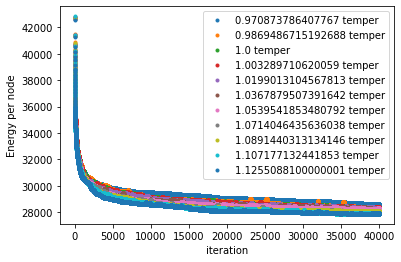

In [23]:
x=np.arange(PasosMC)
for k_nt in range(0,N_t):
    energies_pasos_temper = energies_pasos[k_nt,:] 
    plt.plot(x,energies_pasos_temper,'.',label='%s temper' % tempers[k_nt])
    plt.xlabel('iteration')
    plt.ylabel('Energy per node')
plt.legend()
plt.show()

In [25]:
# Srore in a dictionay
d_store={}string = "emails_5links25year" + schosen + '_3.pickle'
d_store["Datos_energy"] = energies_pasos
d_store["Permus"] = P_t
d_store["Permus_inv"] = P_inv_t
d_store["Permusstore"] = P_store
d_store["L_latent"] = L_t
d_store["temper"] = tempers
d_store["A"] = A
d_store["start_groups"] = start_groups
d_store["end_groups"] = end_groups
d_store["start_anchor"] =start_anchor
d_store["end_anchor"]  = end_anchor
d_store["Anchors"] = Anchors
d_store["size_groups"] = size_groups
d_store["tempers"] = tempers

d_store["P_inter"] = P_intermediate_shot
d_store["E_inter"] = E_intermediate_shot
d_store["E_store"] = Energy_store

file1 = open(string,"wb")
pickle.dump( d_store, file1)


In [26]:
# Voy a construir un diccionario para guardar todo
d_store={}
d_store["Datos_energy"] = energies_pasos
d_store["Permus"] = P_t
d_store["Permus_inv"] = P_inv_t
d_store["Permusstore"] = P_store
d_store["L_latent"] = L_t
d_store["temper"] = tempers
d_store["A"] = A
d_store["start_groups"] = start_groups
d_store["end_groups"] = end_groups
d_store["start_anchor"] =start_anchor
d_store["end_anchor"]  = end_anchor
d_store["Anchors"] = Anchors
d_store["size_groups"] = size_groups
d_store["tempers"] = tempers

d_store["P_inter"] = P_intermediate_shot
d_store["E_inter"] = E_intermediate_shot
d_store["E_store"] = Energy_store

file1 = open(string,"wb")
pickle.dump( d_store, file1)
prueba = pickle.load(open(string, "rb"))